In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import BaggingClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support,
    balanced_accuracy_score,
)

## Training model for different packet sizes. 

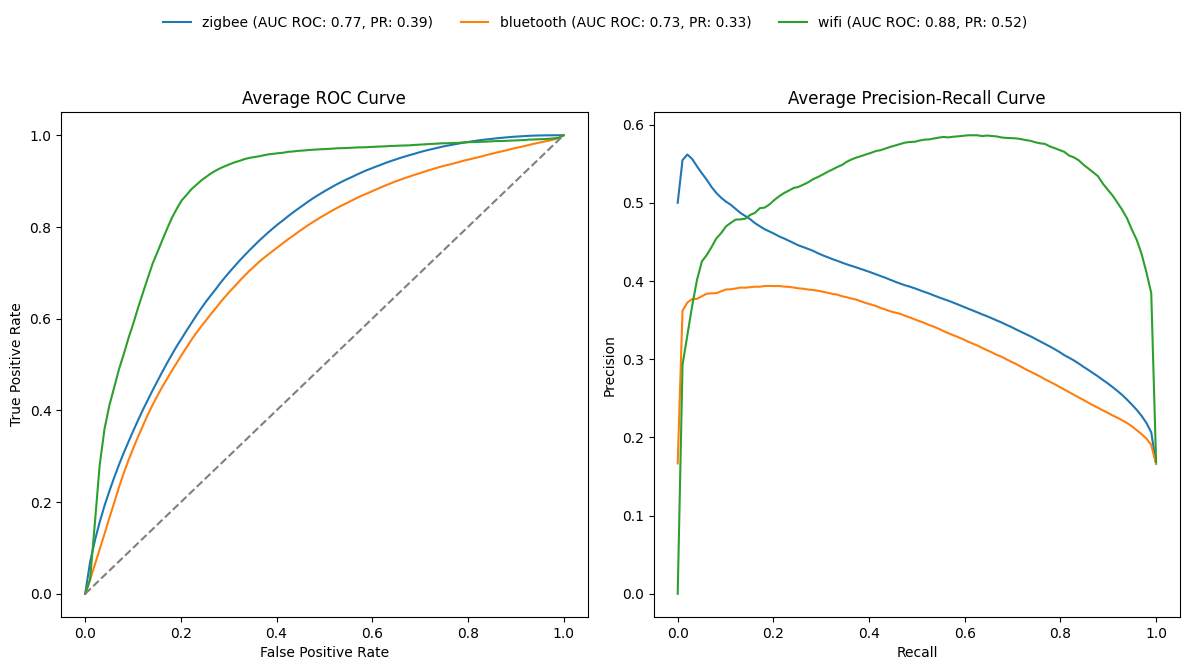

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    auc,
    accuracy_score,
    precision_recall_fscore_support,
)

PROTOCOLS = ["zigbee", "bluetooth", "wifi"]
PROTOCOL_SIZE = {
    "zigbee": 127 * 8,
    "bluetooth": 258 * 8,
    "wifi": 2304 * 8,
}

order = ["mean", "std", "skew", "kurtosis", "energy"]


def load_protocol_data(protocol):
    df = pd.read_parquet(f"data/packets_{PROTOCOL_SIZE[protocol]}_{protocol}.parquet")
    while df["label"].max() > 5:
        df["label"] = df["label"].values // 2

    loaded_files_order = [x for x in os.listdir("data") if x.endswith(".iq")]
    all_data = np.empty((0, 20))
    for file in loaded_files_order:
        data = np.load(f"data/{file[:-3]}_{protocol}.npy")
        all_data = np.concatenate((all_data, data), axis=0)

    col_names = [
        [f"{x}_{i}" for x in order] for i in range(all_data.shape[1] // len(order))
    ]
    col_names = [item for sublist in col_names for item in sublist]

    df[col_names] = pd.DataFrame(all_data)
    df = df.dropna()

    # Drop specified columns
    df = df.drop(
        columns=[x for x in df.columns if "skew" in x or "kurtosis" in x],
        errors="ignore",
    )
    df = df.drop(
        columns=[
            "Z_I",
            "Z_Q",
            "R_I",
            "R_phase",
            "Z_mag",
            "Z_phase",
            "magnitude_error",
            "E_I",
            "E_mag",
            "E_phase",
            "phase_error",
        ],
        errors="ignore",
    )
    return df


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
colors = {"zigbee": "tab:blue", "bluetooth": "tab:orange", "wifi": "tab:green"}

handles = []

for protocol in PROTOCOLS:
    df = load_protocol_data(protocol)
    X = df.drop(columns=["label"])
    y = df["label"].values

    mean_fpr = np.linspace(0, 1, 100)
    mean_recall = np.linspace(0, 1, 100)

    tprs = []
    precisions = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    accuracies = []

    for i in range(6):
        y_current = (y == i).astype(int)
        X_train, X_test, y_train, y_test = train_test_split(X, y_current, test_size=0.2)

        model = svm.LinearSVC(class_weight="balanced", max_iter=10000)
        model.fit(X_train, y_train)
        y_scores = model.decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_scores)
        precision, recall, _ = precision_recall_curve(y_test, y_scores)

        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)

        prec_interp = np.interp(mean_recall, recall[::-1], precision[::-1])
        precisions.append(prec_interp)
        
        y_pred = model.predict(X_test)
        precision_scr, recall_scr, f1_scr, _ = precision_recall_fscore_support(
            y_test, y_pred, average="binary"
        )
        precision_scores.append(precision_scr)
        recall_scores.append(recall_scr)
        f1_scores.append(f1_scr)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    df_results = pd.DataFrame(
        {
            "Accuracy": accuracies,
            "F1": f1_scores,
            "Precision": precision_scores,
            "Recall": recall_scores,
        },
        index=range(6), columns= ["Accuracy", "F1", "Precision", "Recall"]
    ).round(3)
    df_results = df_results[["Accuracy", "F1", "Precision", "Recall"]]
    df_results.to_latex(f"tables/table_4_{protocol}.tex")

    mean_tpr = np.mean(tprs, axis=0)
    mean_precision = np.mean(precisions, axis=0)

    roc_auc = auc(mean_fpr, mean_tpr)
    pr_auc = auc(mean_recall, mean_precision)

    # Plot and collect one handle per protocol
    (line1,) = axes[0].plot(mean_fpr, mean_tpr, color=colors[protocol])
    axes[1].plot(mean_recall, mean_precision, color=colors[protocol])
    handles.append((line1, f"{protocol} (AUC ROC: {roc_auc:.2f}, PR: {pr_auc:.2f})"))

# Format subplots
axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[0].set_title("Average ROC Curve")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

axes[1].set_title("Average Precision-Recall Curve")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")

# Custom legend on top
fig.legend(
    [h[0] for h in handles],
    [h[1] for h in handles],
    loc="upper center",
    ncol=3,
    bbox_to_anchor=(0.5, 1.12),
    frameon=False,
    fontsize="medium",
)
# fig.suptitle("Average ROC and PR Curves per Protocol", y=1.18, fontsize=14)

plt.tight_layout()
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/ROC_PR_4.png", bbox_inches="tight")
plt.show()